# 通过CNN分析价格曲线，预测涨跌  
 
20 x 20=400个工作日  20个月 80个礼拜  => if 未来20个工作日的平均股价 > 当前股价


In [2]:
import baostock as bs
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import matplotlib. pyplot as plt 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Reshape,Dropout,Activation
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

In [33]:
# 读取csv文件
stock_code = "sh.600100"
# stock_code = "300721.SZ"
stock = pd.read_csv("stock_info/" + stock_code + ".csv")

numpy.ndarray

In [35]:
predict_period = 20 
history_period = 400

In [36]:
stock['close'].min(), stock['close'].max()

(5.12, 32.56)

In [38]:
# 归一化
stock['close_nomalized'] = (stock['close']-stock['close'].min())/(stock['close'].max()-stock['close'].min())
stock['future_price'] = stock['close_nomalized'].rolling(predict_period).mean()

In [40]:
# rolling 是向上卷的。 
# 
open_ = ((stock['open']-stock['close'].min())/(stock['close'].max()-stock['close'].min())).values[history_period-1:-predict_period]
y = stock['future_price'][history_period-1:].values[:-predict_period]
y[y - open_ > 0] = 1
y[y - open_ <= 0] = 0
y

array([1., 1., 1., ..., 1., 1., 1.])

In [41]:
# 
n = len(stock)
x = np.array([stock['close_nomalized'][i:i+history_period] for i in range(n-history_period+1)])[20:].reshape(-1, 20, 20)
x=x[:, :, :, np.newaxis]

In [43]:
n, x.shape, y.shape

(2718, (2299, 20, 20, 1), (2299,))

(1839, 20, 20, 1)


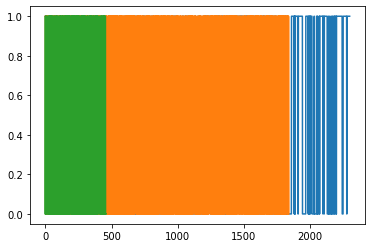

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,shuffle=True)  #拆分数据集，将test集为0.2，参数不同
print(x_train.shape)

plt.plot(y)
plt.plot(y_train)
plt.plot(y_test)

In [45]:
x_train.shape

(1839, 20, 20, 1)

In [25]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(20, 20, 1)))         # 卷积核的个数 => 输出的维度
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 18, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [81]:
model.compile(optimizer='adam', 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))
tf.saved_model.save(model, 'saved_model/')

Epoch 1/20
58/58 [==============================] - 1s 8ms/step - loss: 0.6930 - accuracy: 0.4993 - val_loss: 0.6922 - val_accuracy: 0.4957
Epoch 2/20
58/58 [==============================] - 0s 6ms/step - loss: 0.6840 - accuracy: 0.5551 - val_loss: 0.6916 - val_accuracy: 0.4826
Epoch 3/20
58/58 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5243 - val_loss: 0.6957 - val_accuracy: 0.5130
Epoch 4/20
58/58 [==============================] - 0s 6ms/step - loss: 0.6807 - accuracy: 0.5526 - val_loss: 0.6790 - val_accuracy: 0.5370
Epoch 5/20
58/58 [==============================] - 0s 6ms/step - loss: 0.6727 - accuracy: 0.5671 - val_loss: 0.6588 - val_accuracy: 0.5804
Epoch 6/20
58/58 [==============================] - 0s 6ms/step - loss: 0.6531 - accuracy: 0.5961 - val_loss: 0.6340 - val_accuracy: 0.6370
Epoch 7/20
58/58 [==============================] - 0s 6ms/step - loss: 0.6219 - accuracy: 0.6377 - val_loss: 0.6164 - val_accuracy: 0.6457
Epoch 8/20
58/58 [==

In [20]:
# model = tf.saved_model.load('saved_model/')
# predict
# 读取最近400填收盘价
import baostock as bs

lg = bs.login()
rs = bs.query_history_k_data("sh.600100", "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST", start_date='2010-01-01', end_date='2021-03-11', frequency="d", adjustflag="3")

data_list = []
while (rs.error_code == '0') & rs.next():  # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
print(result)

#### 结果集输出到csv文件 ####   
result.to_csv("sh.600100.csv", index=False)
print(result)

login success!
            date       code     open     high      low    close preclose  \
0     2010-01-04  sh.600100  18.7000  20.5400  18.5500  19.7700  18.7300   
1     2010-01-05  sh.600100  19.6100  20.6500  19.5100  20.0000  19.7700   
2     2010-01-06  sh.600100  19.9300  20.5000  19.6500  20.0200  20.0000   
3     2010-01-07  sh.600100  19.8900  20.2600  19.0500  19.3300  20.0200   
4     2010-01-08  sh.600100  19.2100  20.5200  19.1500  20.3800  19.3300   
...          ...        ...      ...      ...      ...      ...      ...   
2713  2021-03-05  sh.600100   5.9100   6.0100   5.8600   6.0000   5.9000   
2714  2021-03-08  sh.600100   6.0500   6.2800   6.0100   6.1500   6.0000   
2715  2021-03-09  sh.600100   6.1300   6.1700   5.9000   6.0300   6.1500   
2716  2021-03-10  sh.600100   6.0400   6.0800   5.8800   5.9000   6.0300   
2717  2021-03-11  sh.600100   5.9100   5.9800   5.8300   5.9500   5.9000   

        volume           amount adjustflag      turn tradestatus     pct

In [19]:
rs

In [19]:
stock_code = "sh.600100"
# stock_code = "300721.SZ"
stock_info_path = "stock_info/" + stock_code + ".csv"
os.path.exists(stock_info_path)
stock = pd.read_csv(stock_info_path)

In [20]:
os.path.exists(stock_info_path)

True

In [64]:
x[[-1]].reshape(-1, 20, 20, 1).shape

(1, 20, 20, 1)

In [90]:
predictions = model(x[[-1]])

In [75]:
x.dtype

dtype('float64')

In [91]:
score = tf.nn.softmax(predictions[0])

In [93]:
np.argmax(score)

1

In [99]:
class_names = {
    0: "跌",
    1: "涨"
}

In [100]:
print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

This image most likely belongs to 涨 with a 58.16 percent confidence.


5.95